In [1]:
from crocoddyl import *
import pinocchio as pin
import numpy as np

robot = loadBorinotArm()
robot.initViewer(loadModel=True)

q0 = [3.14, 0]
robot.q0.flat = q0
robot.framesForwardKinematics(robot.q0)
robot.display(robot.q0)

IDX_LINK1 = robot.model.getFrameId('link1', pin.FrameType.BODY)
IDX_LINK2 = robot.model.getFrameId('link2', pin.FrameType.BODY)
Mlink1 = robot.data.oMf[IDX_LINK1]
Mlink2 = robot.data.oMf[IDX_LINK2]

target_pos  = np.array([0,0,0.3])
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

Mref = pin.SE3()
Mref.translation = target_pos.reshape(3,1)
Mref.rotation = target_quat.matrix()

#robot.viewer.gui.addXYZaxis('world/framelink1', [1., 0., 0., 1.], .005, 0.05)
#robot.viewer.gui.addXYZaxis('world/framelink2', [1., 0., 0., 1.], .005, 0.05)
#robot.viewer.gui.addXYZaxis('world/frameref', [1., 0., 0., 1.], .005, 0.05)

#robot.viewer.gui.applyConfiguration('world/framelink1', pin.se3ToXYZQUATtuple(Mlink1))
#robot.viewer.gui.applyConfiguration('world/framelink2', pin.se3ToXYZQUATtuple(Mlink2))
#robot.viewer.gui.applyConfiguration('world/frameref', pin.se3ToXYZQUATtuple(Mref))

robot.viewer.gui.refresh()

In [2]:
import time 
dt = 0.05
t = np.arange(0,3,dt)
q0 = np.array([3.14, 0])

q = q0
q_d = np.zeros([2])
q_dd = np.zeros([2])

In [3]:
for i in range(len(t)):
    pin.computeAllTerms(robot.model, robot.data, a2m(q), a2m(q_d))
    M = robot.data.M
    Minv = np.linalg.inv(M)
    r = np.zeros(2)
    tau = np.zeros([2])
    r = tau - m2a(robot.data.nle) 
    q_dd = np.dot(Minv, r)
    q = q + q_d*dt + q_dd*dt**2
    q_d = q_d + q_dd*dt
    pin.forwardKinematics(robot.model, robot.data, a2m(q), a2m(q_d))
    robot.display(a2m(q))
    time.sleep(0.01)

In [16]:
state = StatePinocchio(robot.model)

xRegCost = CostModelState(robot.model, state, ref=state.zero(), nu=1)
uRegCost = CostModelControl(robot.model, nu = 1)
xPendCost = CostModelDoublePendulum(robot.model, 
                                    frame=state, 
                                    ref=state.zero, 
                                    nu=1,
                                    activation=ActivationModelWeightedQuad(np.array([10,1,10,1]+[0.1]*2))) 

runningCostModel = CostModelSum(robot.model, nu=1)
terminalCostModel = CostModelSum(robot.model, nu=1)

runningCostModel.addCost(name="regx", weight=1e-6, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
runningCostModel.addCost(name="pend", weight=1, cost=xPendCost)
terminalCostModel.addCost(name="ori2", weight=50, cost=xPendCost)

In [14]:
np.array([1,1,1,1,1,1])

array([1, 1, 1, 1, 1, 1])

In [17]:
actModel = ActuationModelDoublePendulum(robot.model)
runningModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, terminalCostModel))

In [18]:
# Defining the time duration for running action models and the terminal one
dt = 5e-2
runningModel.timeStep = dt

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 60
x0 = np.array([3.14, 0, 0., 0. ])
problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

In [21]:
# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

us0 = np.zeros([60,1])
us0 = us0 + 4
xs0 = [problem.initialState]*len(ddp.models())

#ddp.solve(init_xs=xs0,init_us=us0,maxiter=600)
ddp.solve(maxiter=600)
# Solving it with the DDP algorithm
#ddp.solve()

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  3.69322e+01  4.00077e-01  -2.42118e+05  1.00000e-09  1.00000e-09   0.0156     0
   1  1.06958e+02  1.09817e+04  -1.53840e+05  1.00000e-09  1.00000e-09   0.0156     0
   2  1.63942e+02  1.20163e+04  -6.61968e+04  1.00000e-09  1.00000e-09   0.0156     0
   3  2.15054e+02  2.44469e+04  -2.73148e+04  1.00000e-09  1.00000e-09   0.0156     0
   4  2.81349e+02  7.90349e+04  -1.02097e+04  1.00000e-09  1.00000e-09   0.0312     0
   5  2.99798e+02  2.11671e+05  -1.16727e+03  1.00000e-09  1.00000e-09   0.0312     0
   6  2.97934e+02  2.62602e+05  -2.79618e+02  1.00000e-09  1.00000e-09   0.0625     0
   7  3.86648e+02  2.79628e+05  -9.03739e+01  1.00000e-09  1.00000e-09   0.1250     0
   8  3.56496e+02  3.05065e+05  2.10063e+02  1.00000e-09  1.00000e-09   0.1250     0
   9  3.34571e+02  3.18361e+05  1.98154e+02  1.00000e-09  1.00000e-09   0.0625     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  90  5.79916e+02  2.62083e+04  2.93626e+01  1.00000e-09  1.00000e-09   0.2500     0
  91  5.76686e+02  2.13074e+04  2.46840e+01  1.00000e-09  1.00000e-09   0.2500     0
  92  5.75554e+02  1.69815e+04  2.22984e+01  1.00000e-09  1.00000e-09   0.2500     0
  93  5.73421e+02  1.80388e+04  2.96336e+01  1.00000e-09  1.00000e-09   0.1250     0
  94  5.71645e+02  1.27997e+04  1.82280e+01  1.00000e-09  1.00000e-09   0.2500     0
  95  5.70015e+02  1.20544e+04  2.08043e+01  1.00000e-09  1.00000e-09   0.1250     0
  96  5.68817e+02  9.56750e+03  1.52030e+01  1.00000e-09  1.00000e-09   0.2500     0
  97  5.67363e+02  1.04158e+04  1.87783e+01  1.00000e-09  1.00000e-09   0.1250     0
  98  5.66095e+02  9.08136e+03  1.50942e+01  1.00000e-09  1.00000e-09   0.2500     0
  99  5.64302e+02  8.77571e+03  1.74565e+01  1.00000e-09  1.00000e-09   0.2500     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
 100  5.62333e

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
 180  5.35635e+02  4.69500e+01  5.18769e-02  1.00000e-09  1.00000e-09   0.2500     0
 181  5.35628e+02  7.27644e+01  1.24725e-01  1.00000e-09  1.00000e-09   0.1250     0
 182  5.35624e+02  4.89416e+01  5.54115e-02  1.00000e-09  1.00000e-09   0.2500     0
 183  5.35617e+02  8.00134e+01  1.40884e-01  1.00000e-09  1.00000e-09   0.1250     0
 184  5.35613e+02  5.29710e+01  6.08276e-02  1.00000e-09  1.00000e-09   0.2500     0
 185  5.35604e+02  9.00227e+01  1.60363e-01  1.00000e-09  1.00000e-09   0.1250     0
 186  5.35600e+02  5.95614e+01  6.84421e-02  1.00000e-09  1.00000e-09   0.2500     0
 187  5.35590e+02  1.03630e+02  1.83770e-01  1.00000e-09  1.00000e-09   0.1250     0
 188  5.35585e+02  6.98350e+01  7.90273e-02  1.00000e-09  1.00000e-09   0.2500     0
 189  5.35574e+02  1.22536e+02  2.12322e-01  1.00000e-09  1.00000e-09   0.1250     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
 190  5.35566e

KeyboardInterrupt: 

In [20]:
displayTrajectory(robot, ddp.xs, runningModel.timeStep)

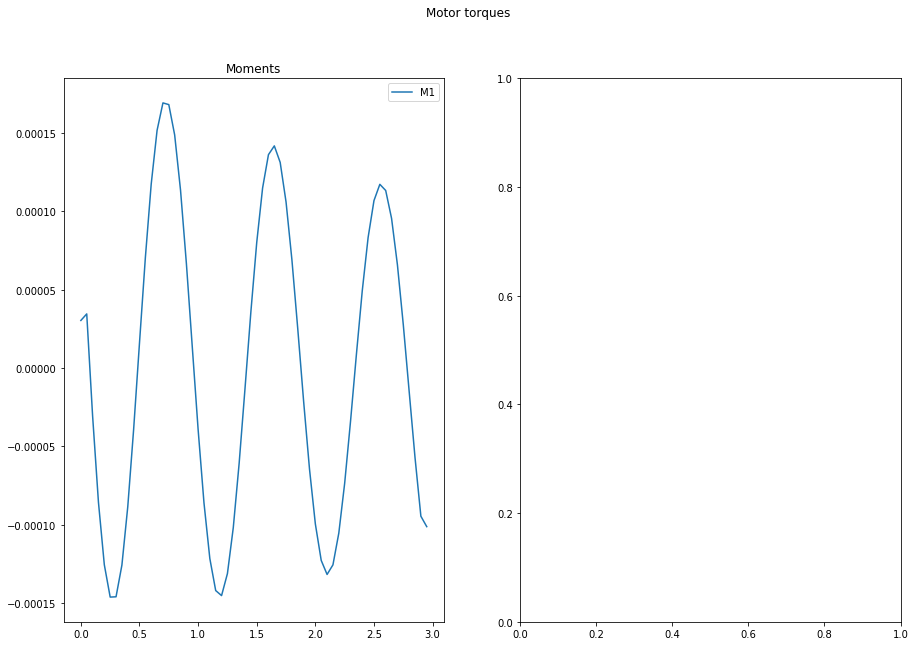

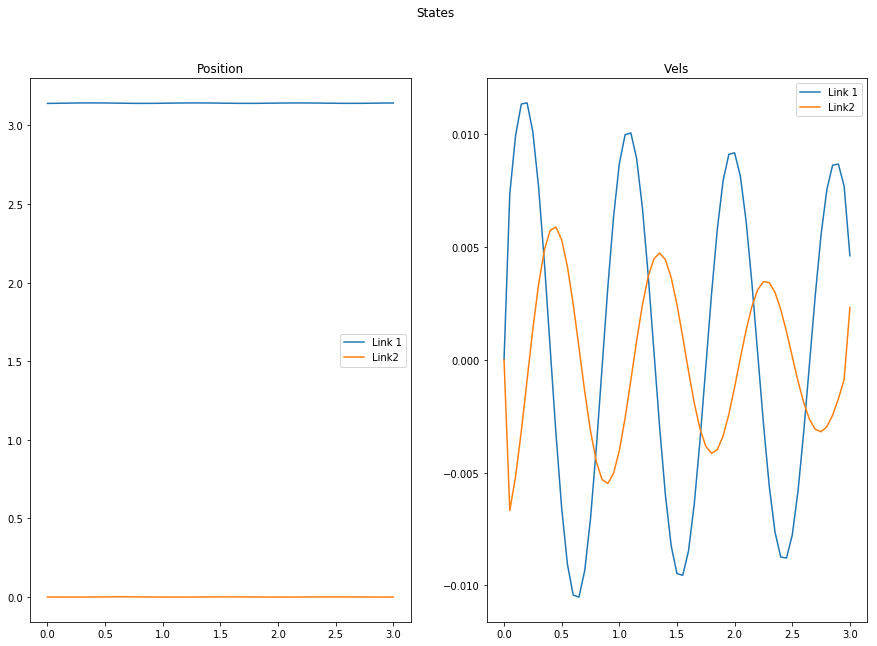

In [12]:
import numpy as np
import matplotlib.pyplot as plt

control = np.vstack(ddp.us)
t = np.arange(0,T*dt, dt)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('Motor torques')
# axs[0].plot(t,control[:,0], t,control[:,1])
axs[0].plot(t,control[:,0])
axs[0].set_title('Moments')
axs[0].legend(['M1','M2'])

t_state = np.append(t, t[-1]+dt)
state = np.vstack(ddp.xs)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('States')
axs[0].plot(t_state,state[:,0], t_state, state[:,1])
axs[0].set_title('Position')
axs[0].legend(['Link 1','Link2'])
axs[1].plot(t_state,state[:,2], t_state, state[:,3])
axs[1].set_title('Vels')
axs[1].legend(['Link 1','Link2'])

In [ ]:
H = np.zeros([6, 4])
c1 = 1
c2 = 1
s1 = 0
s2 = 0
H[:2,:2] = np.diag([c1**2-s1**2, c2**2-s2**2])
H[2:4,:2] = np.diag([s1**2+(1-c1)*c1, s2**2+(1-c2)*c2])
H[4:6,2:4] = np.diag([1,1])
weights = np.array([10]*4 + [0.1]*2)
Axx = weights[:, None]
Lxx = np.dot(H.T, Axx)
Lxx
L = np.zeros([4,4])
L[:,:] = np.diag([Lxx[0,0], Lxx[1,0], Lxx[2,0], Lxx[3,0]])
L